## Import Library

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torchvision.models import inception_v3
from torchvision.models import vgg16
import time
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path='/content/drive/MyDrive/FaceReco/Dataset'

In [ ]:
os.listdir(data_path)

['class_identity.txt',
 'gender_classification.csv',
 'list_attribute.txt',
 'gender_classification.xlsx',
 'Images',
 'Images_clean']

In [ ]:
images_list = os.listdir(data_path+'/Images')

In [ ]:
# Membaca file list_attribute.txt yang berisi informasi atribut gambar. Merapikan data dengan separasi spasi dan skip kolom metadata
data = pd.read_csv(data_path+'/list_attribute.txt', sep='\s+', skiprows=1)

# images_list berisi nama file 5000 gambar yang benar-benar ada.
# Kode ini menyaring agar hanya atribut gambar tersebut yang diambil.
filtered_data = data[data.index.isin(images_list)]

# Hanya kolom 'Male' yang diambil dari dataset. reset_index() mengubah nama gambar dari index menjadi kolom biasa.
filtered_data = filtered_data[['Male']].reset_index()

# Kolom yang berisi nama gambar diubah namanya menjadi image_id agar lebih jelas.
filtered_data = filtered_data.rename(columns={'index': 'image_id'})

# Awalnya data 'Male' berisi 1 (laki-laki) dan -1 (bukan laki-laki). Diubah menjadi 1 (laki-laki) dan 0 (bukan laki-laki) supaya cocok untuk model machine learning.
filtered_data['Male'] = filtered_data['Male'].apply(lambda x: 1 if x == 1 else 0)

# Buat variabel filtered_data dengan data
data = filtered_data

print(data.head())
print(data.shape)
print("Unique values in 'Male' column after conversion:", data['Male'].unique())

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-333735229.py:2: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(data_path+'/list_attribute.txt', sep='\s+', skiprows=1)


     image_id  Male
0  000051.jpg     1
1  000052.jpg     1
2  000352.jpg     1
3  000409.jpg     1
4  000545.jpg     1
(1768, 2)
Unique values in 'Male' column after conversion: [1 0]


In [ ]:
# split the data into train and test sets with a 80:20 ratio
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

## Preprocessing

In [ ]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])
        image = Image.open(image_path).convert('RGB') # convert image to RGB
        gender = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),           # resize ke 299x299 (ukuran input Inception V3)
    transforms.RandomHorizontalFlip(p=0.5),  # augmentasi: flipping kiri/kanan
    transforms.ColorJitter(                  # augmentasi: variasi warna/kontras
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),

    transforms.ToTensor(),                   # ubah ke tensor [0,1]
    transforms.Normalize(                    # normalisasi pakai mean & std ImageNet
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
train_set = GenderDataset(train_data, image_folder_path=os.path.join(data_path, "Images"), transform=transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)

test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform=transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

## Architecture

In [ ]:
# please define the model optimizer and criterion (loss function)
model = inception_v3(pretrained=True, aux_logits=True)
# Modifikasi layer terakhir untuk tugas classification (2 classes: Male/Female)
# Inception V3 mempunyai struktur layer terakhir yang berbeda, seperti Linear layer yang diikuti oleh AuxLogits layer (sebagai layer bantuan agar model stabil).
# Kita modifikasi Linear Layer dan AuxLogits Layernya.
num_ftrs = model.fc.in_features
# Tambahkan dropout layer pada classification layer terakhir untuk meminimalisir overfitting
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # atur nilai dropout sebesar 0.5
    nn.Linear(num_ftrs, 2)
)

# Modifikasi AuxLogits Layer
num_aux_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Sequential(
    nn.Dropout(0.3), # tambahkan dropout layer dan atur nilai dropout sebesar 0.3
    nn.Linear(num_aux_ftrs, 10)
)

# Define optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) #Gunakan optimizer Adam agar model lebih konvergen, gunakan juga weight decay agar weight/ bobot tidak terlalu besar
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss untuk multiclass classification

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 157MB/s] 


## Modeling

In [ ]:
import time
import copy
from torch.autograd import Variable

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu=torch.cuda.is_available(), num_epochs=10, patience=5, min_delta=0.001):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # buat copy / model cadangan
    best_acc = 0.0 # Set akurasi terbaik mulai dari 0

    train_acc_history = []
    test_acc_history = []
    train_loss_history = []
    test_loss_history = []

    epochs_no_improve = 0 # Variabel epochs_no_improve dipakai untuk menghitung berapa kali berturut-turut akurasi test/validasi tidak membaik. Training berhenti otomatis ketika sudah jelas tidak ada perbaikan, hal ini dapat meminimalisir overfitting

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and evaluation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # alat ukur yang bikin kita bisa tahu apakah overfitting terjadi.

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu: # Gunakan GPU jika ada (agar proses training lebih cepat)
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else: # Jika tidak ada GPU, gunakan CPU (lebih lambat dari GPU)
                    inputs = Variable(inputs)
                    labels = Variable(labels)
                    # Jika training berjalan lambat, ada potensi training berhenti di tengah jalan, hal ini akan menyebabkan model underfitting

                # zero the parameter gradients
                optimizer.zero_grad() # mengosongkan gradien lama sebelum hitung gradien baru.
                # Jika tiap batch dilakukan zero_grad, Model akan update bobot dengan informasi yang jernih, sehingga akurasi train & test lebih stabil.

                # forward
                if phase == 'train':
                    # Inception V3 hanya mengeluarkan 2 output yaitu output dari main classifier dan output dari auxillaries classifier
                    outputs, aux_outputs = model(inputs)
                    loss1 = criterion(outputs, labels) # loss dari main classifier
                    loss2 = criterion(aux_outputs, labels) # loss dari auxillaries classifier
                    loss = loss1 + 0.4 * loss2 # auxillaries hanya diberi 40 % dari nilai lossnya karena hanya sebagai jalur bantuan
                else:
                    # di evaluation mode,hanya output dari main classifier saja yang digunakan
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)


                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward() # inti dari deep learning. Tanpa ini, bobot tidak akan pernah belajar dari kesalahan.
                    optimizer.step() # kalau ini tidak ada, model akan stuck dengan bobot awal (tidak ada perbaikan).

                # statistics
                running_loss += loss.data * inputs.size(0) # Multiply by batch size for correct loss calculation
                _, preds = torch.max(outputs.data, 1)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] # Convert to double for accurate division

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
                train_loss_history.append(epoch_loss.item())
            else:
                test_acc_history.append(epoch_acc.item())
                test_loss_history.append(epoch_loss.item())

            # deep copy the model if test accuracy improved
            if phase == 'test':
                if epoch_acc > best_acc + min_delta:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve == patience:
                        print("Early stopping!")
                        time_elapsed = time.time() - since
                        print('Training complete in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60))
                        print('Best test Accuracy: {:4f}'.format(best_acc)) # Corrected print statement
                        model.load_state_dict(best_model_wts)
                        return model, train_acc_history, test_acc_history, train_loss_history, test_loss_history


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Accuracy: {:4f}'.format(best_acc)) # Corrected print statement

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, test_acc_history, train_loss_history, test_loss_history

In [ ]:
dataloders = {
    "train":train_loader, "test":test_loader
}
dataset_sizes= {
    "train":len(train_set), "test":len(test_set)
}

In [ ]:
use_gpu = torch.cuda.is_available()

if use_gpu:
  # The train_model function returns a tuple, the first element is the model
  model = model.to("cuda")
else:
  model = model

In [ ]:
model, train_acc_history, test_acc_history, train_loss_history, test_loss_history = train_model(model, dataloders, dataset_sizes, criterion, optimizer, use_gpu, 10)

Epoch 0/9
----------
train Loss: 0.0167 Acc: 0.9979
test Loss: 0.1066 Acc: 0.9661

Epoch 1/9
----------
train Loss: 0.0285 Acc: 0.9943
test Loss: 0.0940 Acc: 0.9605

Epoch 2/9
----------
train Loss: 0.0225 Acc: 0.9943
test Loss: 0.1237 Acc: 0.9605

Epoch 3/9
----------
train Loss: 0.0078 Acc: 0.9993
test Loss: 0.0893 Acc: 0.9718

Epoch 4/9
----------
train Loss: 0.0194 Acc: 0.9958
test Loss: 0.2392 Acc: 0.9124

Epoch 5/9
----------
train Loss: 0.0222 Acc: 0.9936
test Loss: 0.1091 Acc: 0.9746

Epoch 6/9
----------
train Loss: 0.0218 Acc: 0.9943
test Loss: 0.1043 Acc: 0.9576

Epoch 7/9
----------
train Loss: 0.0048 Acc: 0.9993
test Loss: 0.0903 Acc: 0.9689

Epoch 8/9
----------
train Loss: 0.0058 Acc: 0.9993
test Loss: 0.0900 Acc: 0.9689

Epoch 9/9
----------
train Loss: 0.0021 Acc: 1.0000
test Loss: 0.0970 Acc: 0.9633

Training complete in 2m 23s
Best test Accuracy: 0.974576


## Evaluation

In [ ]:
def evaluate_model(model, test_loader, target_labels):
    # please define the evaluation function here
    model.eval() # Set model to evaluate mode

    all_preds = []
    all_labels = []

    with torch.no_grad(): # Disable gradient calculation for evaluation
        for inputs, labels in test_loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=target_labels))

    # Print confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    return all_labels, all_preds

In [ ]:
all_labels, all_preds = evaluate_model(model, dataloders['test'], ["female", "male"])

              precision    recall  f1-score   support

      female       1.00      0.97      0.98       214
        male       0.95      1.00      0.98       140

    accuracy                           0.98       354
   macro avg       0.98      0.98      0.98       354
weighted avg       0.98      0.98      0.98       354

Confusion Matrix:
[[207   7]
 [  0 140]]


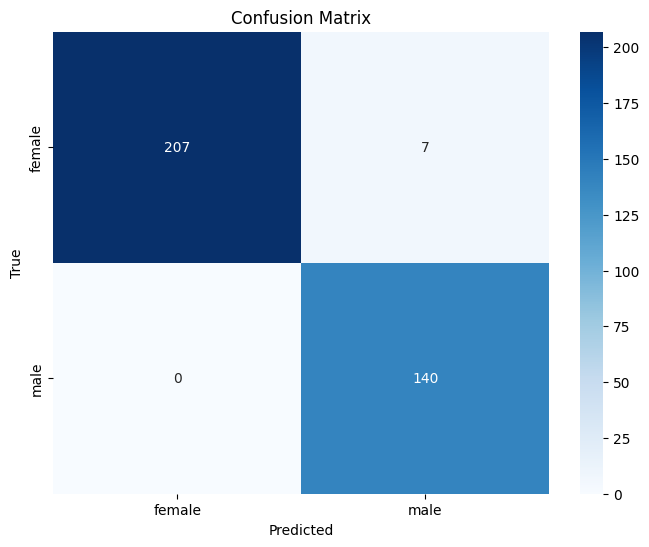

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues', xticklabels=["female", "male"], yticklabels=["female", "male"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

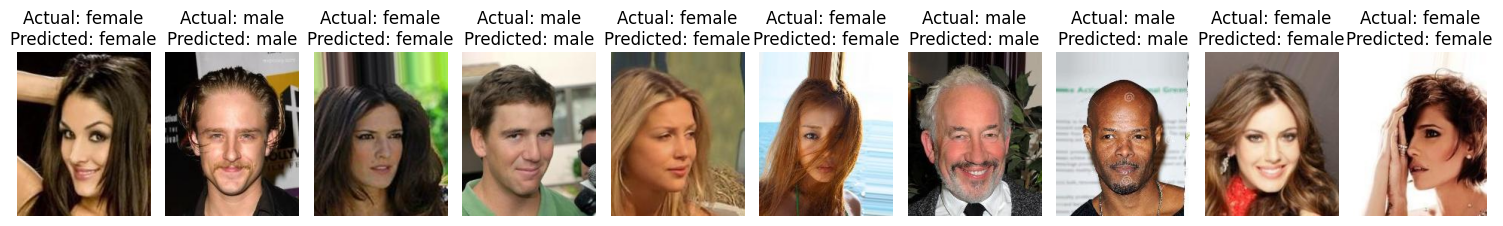

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# ambil 5 prediksi random dari test_data
random_indices = random.sample(range(len(test_data)), 10)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    # Ambil image path dan label
    img_name = test_data.iloc[idx, 0]
    actual_label = "male" if test_data.iloc[idx, 1] == 1 else "female"
    img_path = os.path.join(data_path, "Images", img_name)

    # Load dan preprocess gambar
    image = Image.open(img_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)

    # Alihkan ke GPU jika pakai GPU
    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()

    # Ambil prediksi model
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)
        predicted_label = "male" if preds.item() == 1 else "female"

    # Tampilkan gambar dan label
    plt.subplot(1, 10, i + 1)
    plt.imshow(image)
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

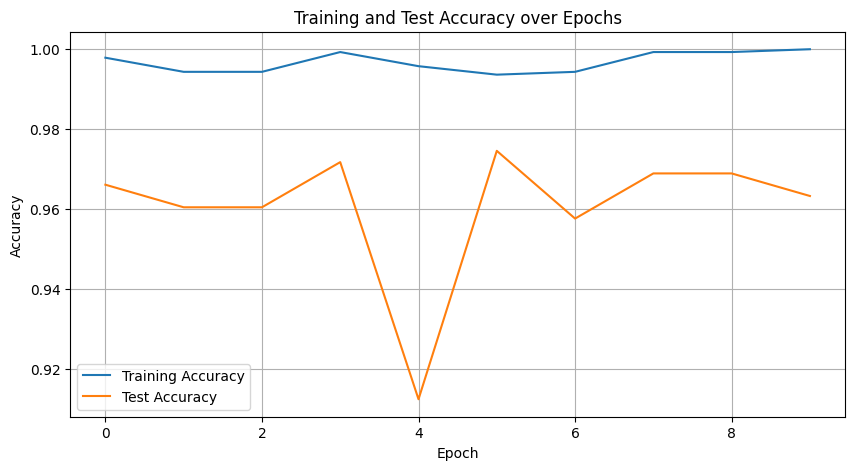

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

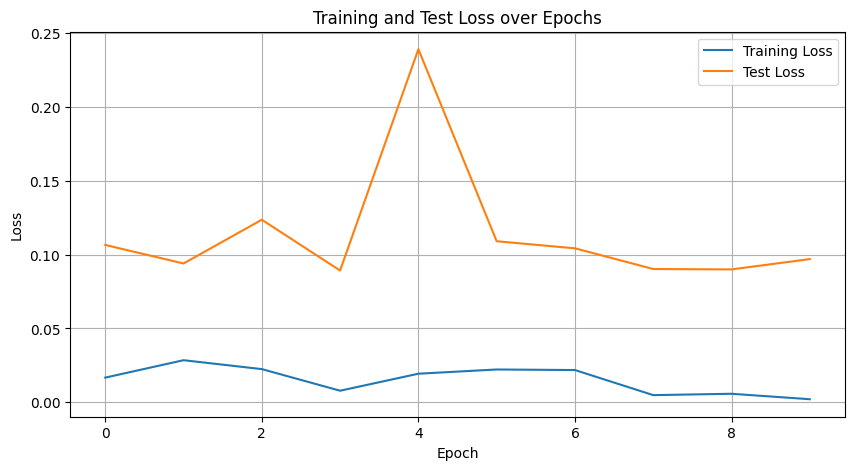

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()